In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras as ke
from tensorflow.keras.utils import to_categorical

import os

from tensorflow.keras.layers import Dense, BatchNormalization


import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.layers import Dense, BatchNormalization

import random
from itertools import permutations

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR

%matplotlib inline

In [2]:
#df_normal = pd.read_csv('./data_normal_clean.csv', sep = ',')
#df_normal

In [3]:
#df_normal_young = df_normal[df_normal['Group']<=26].copy()
#df_normal_young = df_normal_young.reset_index(drop=True)
#big_group = [[1],[2],[3,4],[5,6],[7,8,9],[10,11,12,13],[14,15,16,17],[18,19,20,21],[22,23,24,25,26]]
#group_dic = {}
#big_group_id = 1
#for group_list in big_group:
#    for i in group_list:
#        group_dic[i] = big_group_id
#    big_group_id+=1

In [4]:
#group_num = df_normal_young['Group'].values
#new_list  = []
#for i in range(len(group_num)):
#    new_list.append(group_dic[int(group_num[i])])
#new_df = pd.DataFrame({'Group': new_list})
#df_normal_young.update(new_df)

In [5]:
# Extract X by excluding 'Gender' column
#X = df_normal_young.drop(['Gender'], axis=1).to_numpy()

# Extract 'Gender' column
#y = df_normal_young['Gender'].to_numpy()





In [6]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
epochs = 100
batch_size = 256
logging_step = 5

#z_dim = 100
image_shape = (21, 8,1)
hidden_layer_size = 512

relu_leak = 0.2
init_lr = 0.00001

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(learning_rate=init_lr, beta_1=0.5)

In [8]:
file_path_train = './normal_AllGender/train.csv'
#file_path_test =  './normal_AllGender/valid.csv'
file_path_test =  './normal_AllGender/test.csv'



df_train = pd.read_csv(file_path_train, sep = ',')

# Extract 'Group' and 'Gender' columns
group = df_train['Group'].to_numpy()
gender = df_train['Gender'].to_numpy()

# Combine 'Group' and 'Gender' columns into a single label column
y_train = gender* 10 + group 

df_train = df_train.drop(['Gender'], axis=1)
X_train = df_train.drop(['Group'], axis=1)




df_test = pd.read_csv(file_path_test, sep = ',')

# Extract 'Group' and 'Gender' columns
group = df_test['Group'].to_numpy()
gender = df_test['Gender'].to_numpy()

# Combine 'Group' and 'Gender' columns into a single label column
y_test = gender* 10 + group 


df_test = df_test.drop(['Gender'], axis=1)
X_test = df_test.drop(['Group'], axis=1)



X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [9]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data using the scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train = X_train.reshape(X_train.shape[:-1] + image_shape)
X_test = X_test.reshape(X_test.shape[:-1] + image_shape)

In [11]:
from sklearn.preprocessing import LabelBinarizer

# Initialize the LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the labels
y_test = label_binarizer.fit_transform(y_test)


# Fit and transform the labels
y_train = label_binarizer.fit_transform(y_train)

In [12]:
models_prefix = 'Resnetmodelsgender/'
images_prefix = 'Resnetimagesgender/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

In [13]:
def create_resnet_model(input_shape, num_classes):
    # Define the input layer
    inputs = ke.Input(shape=input_shape)

    # Initial convolutional layer
    x = ke.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.Activation('relu')(x)
    x = ke.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=32, blocks=2, strides=(1, 1))
    x = residual_block(x, filters=64, blocks=2, strides=(2, 2))

    # Global average pooling and dense layer for classification
    x = ke.layers.GlobalAveragePooling2D()(x)
    x = ke.layers.Dense(hidden_layer_size, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.LeakyReLU(relu_leak)(x)
    x = ke.layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer)(x)

    # Create the model
    model = ke.Model(inputs=inputs, outputs=x)
    
    return model


In [14]:

def residual_block(inputs, filters, blocks, strides):
    x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.Activation('relu')(x)

    for _ in range(blocks - 1):
        shortcut = x
        x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
        x = ke.layers.BatchNormalization()(x)
        x = ke.layers.Activation('relu')(x)
        x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
        x = ke.layers.BatchNormalization()(x)
        x = ke.layers.Add()([x, shortcut])
        x = ke.layers.Activation('relu')(x)

    return x



In [15]:
# Create the ResNet model for classification
model = create_resnet_model(input_shape=image_shape,num_classes=18)

2023-07-19 17:49:16.075668: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 17:49:16.076034: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [16]:

compile_model = 0


if compile_model:
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

In [17]:
import os
save_model = 1

if save_model:
    
    # Create the directory if it doesn't exist
    if not os.path.exists(models_prefix):
        os.makedirs(models_prefix)

    # Save the model's architecture in a JSON file
    model_json = model.to_json()
    with open(os.path.join(models_prefix, 'model_architecture.json'), 'w') as json_file:
        json_file.write(model_json)

    # Save the model's weights in an HDF5 file
    #model.save_weights(os.path.join(models_prefix, 'model_weights.h5'))

In [18]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file
with open(os.path.join(models_prefix, 'model_architecture.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights from the HDF5 file
loaded_model.load_weights(os.path.join(models_prefix, 'model_weights.h5'))

# Compile the loaded model
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file
with open(os.path.join(models_prefix, 'model_architecture.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights from the HDF5 file
loaded_model.load_weights(os.path.join(models_prefix, 'model_weights.h5'))

# Compile the loaded model
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
def split_X_by_similar_group(X, y):
    groups = get_group_from_y(y)  # Assuming you have a function get_group_from_y(y) that returns the group for each y value
    
    # Create lists to store the arrays for each group
    Xs = []
    ys = []
    
    # Iterate over the unique groups and split X and y accordingly
    for group in set(groups):
        mask = groups == group
        X_group = X[mask]
        y_group = y[mask]
        Xs.append(X_group)
        ys.append(y_group)
    
    return Xs, ys

In [32]:
def get_group_from_y(y):
    group = label_binarizer.inverse_transform(y) % 10  # reminder to 10 to get the group
    return group

In [33]:
def get_gender_from_y(y):
    gender = label_binarizer.inverse_transform(y) // 10  # Divide by 10 to get the gender
    return gender

In [34]:
X_trains,y_trains = split_X_by_similar_group(X_train,y_train)
X_tests,y_tests = split_X_by_similar_group(X_test,y_test)

In [51]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def resnetclassifier(X_t, y_t, group):
    # Use the loaded model to make predictions on the test set
    y_pred = loaded_model.predict(X_t)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_classes = y_pred_classes//10

    # Calculate the accuracy score
    accuracy = accuracy_score(y_t, y_pred_classes)

    # Calculate F1 score
    f1 = f1_score(y_t, y_pred_classes, average='macro')

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_t, y_pred_classes)
    roc_auc = roc_auc_score(y_t, y_pred_classes)

    # Visualize the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc) + ' , F1 = {:.2f})'.format(f1))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Save the graph as a high-resolution TIFF image (optional)
    name = images_prefix + 'ResnetROC' + str(group)
    plt.savefig(name + '.tiff', dpi=300)

    # Show the plot
    plt.show()

    # Return the evaluation metrics
    return accuracy, f1, roc_auc


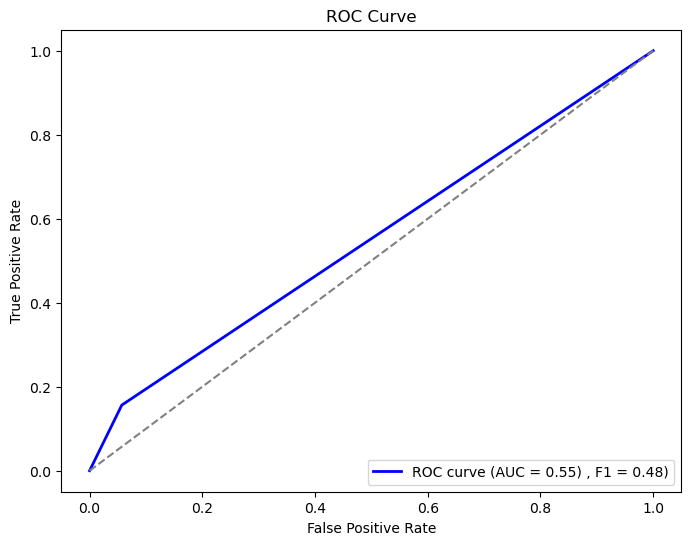

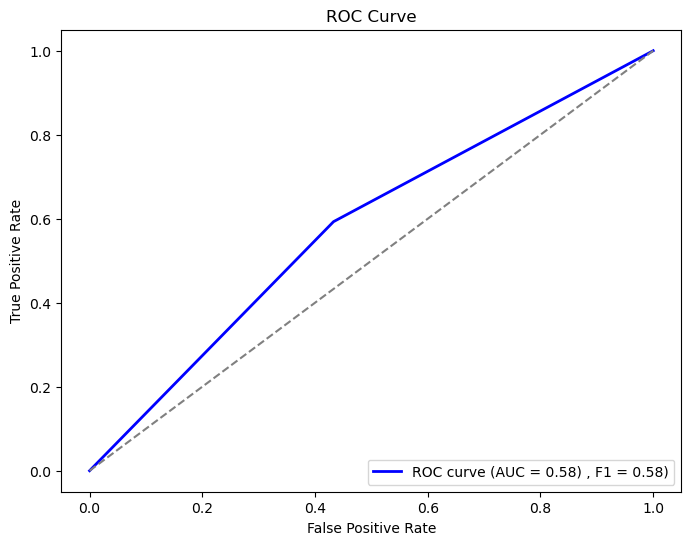

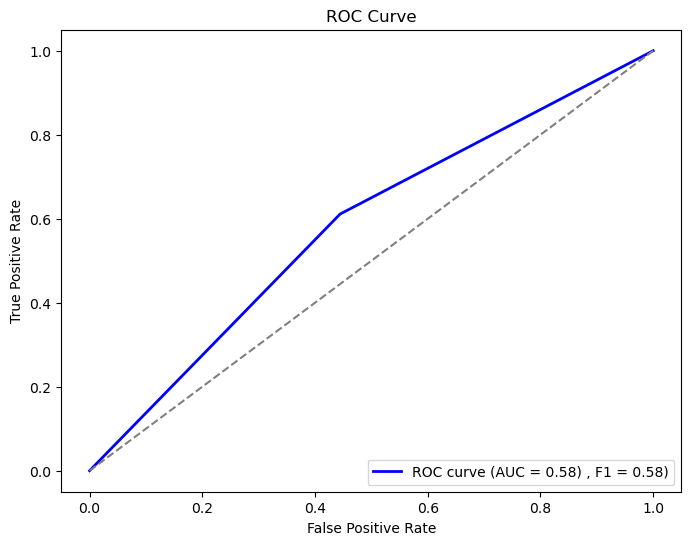

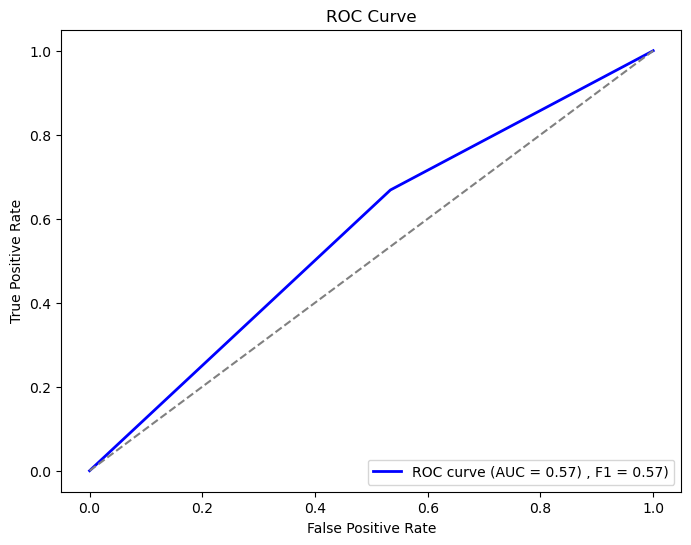

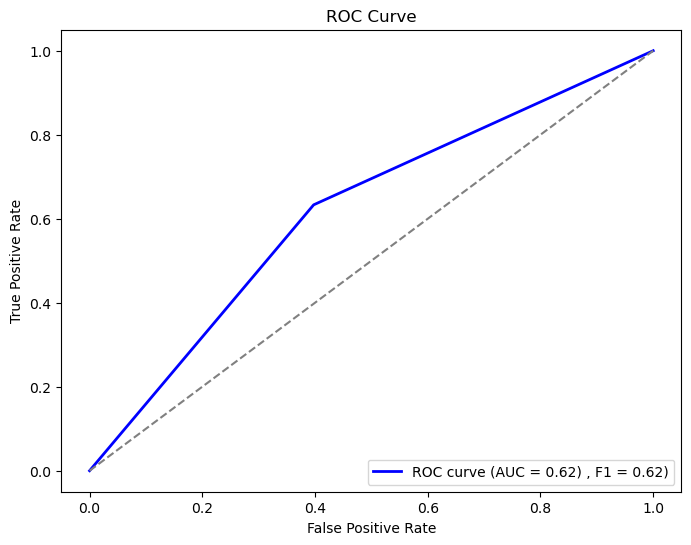

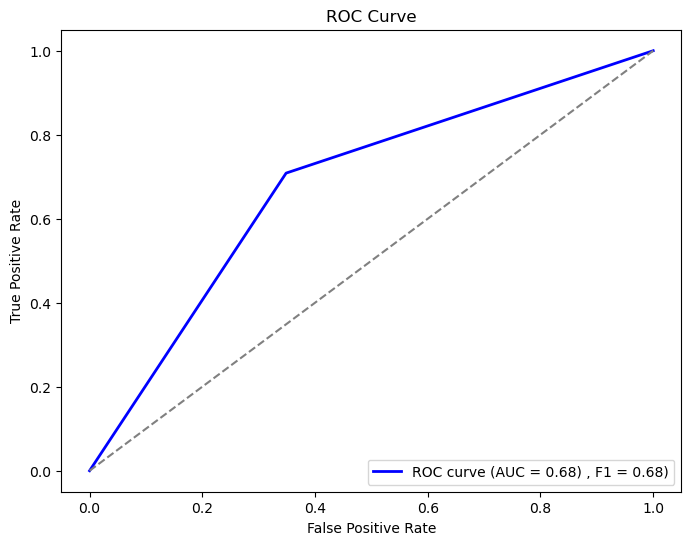

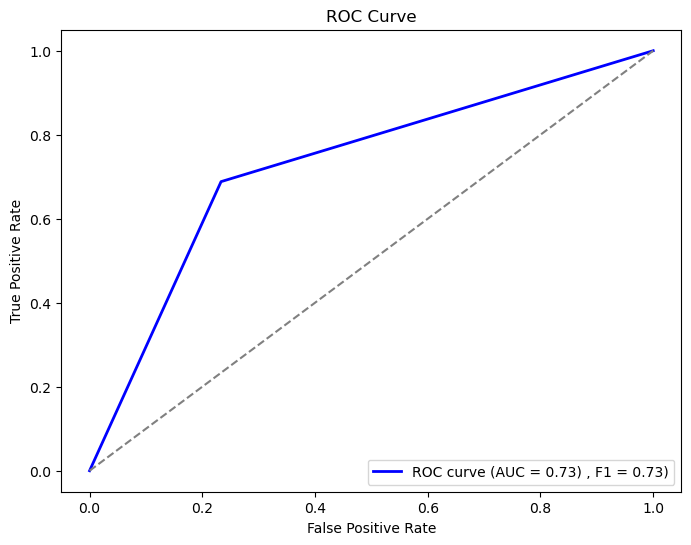

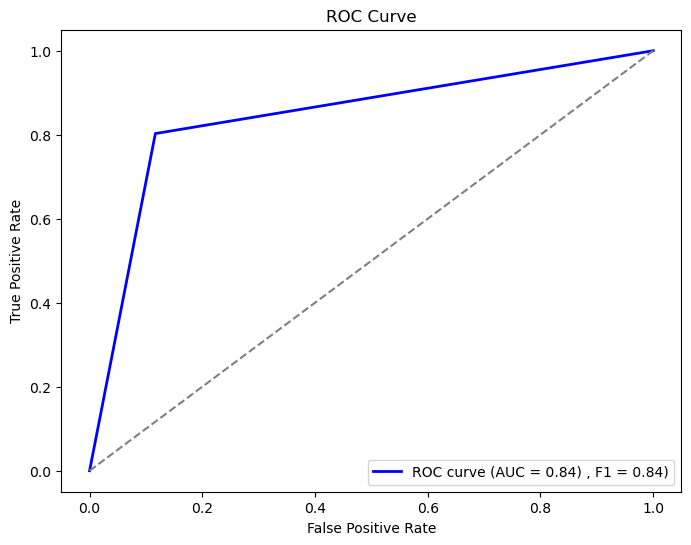

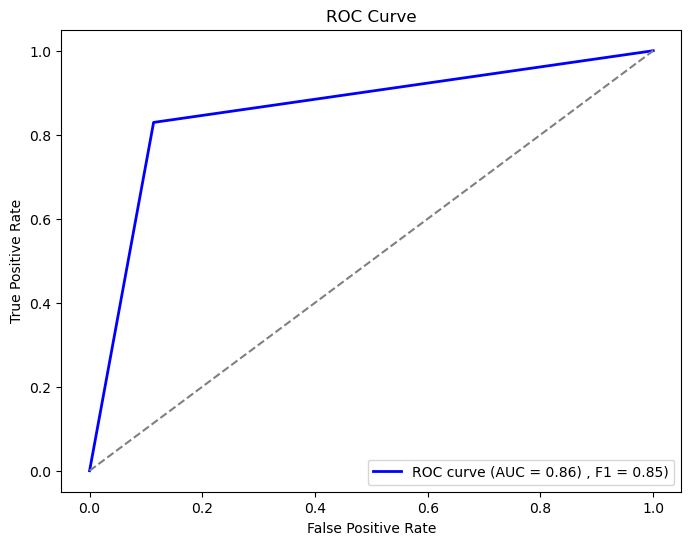

In [53]:
group = 1
for Xg_train, Xg_test, yg_train, yg_test in zip(X_trains, X_tests, y_trains, y_tests):
    
    resnetclassifier(Xg_test, get_gender_from_y(yg_test), group)
    group += 1